# Variational Quantum Eigensolver For Quantum Harmonic Oscillator

In this tutorial we will be going through how to use the CV-TFQ library to set up and find the ground state of the Quantum Harmonic Oscillator (QHO) with the Variational Quantum Eigensolver (VQE). The QHO is a quantum version of the common classical harmonic oscillator. The QHO is defined by the hamiltonian $\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2} m \omega^2 \hat{x}^2$. The wavefunctions for different energy levels are $\psi_n(x) = \frac{1}{\sqrt{2^n n!}} \left ( \frac{m \omega}{\pi \hbar} \right )^{1/4} e^{-\frac{m \omega x^2}{2 \hbar} H_n(x)}$ where $H_n$ is the Hermite polynomial. For the lowest energy level, this results in a Guassian. 

VQE as used in this tutorial is the same as traditional VQE methods. Assuming our (CV) hamiltonian $\hat{H}$, we approximate the solution to the objective function via $\min_\theta \langle \Psi (\theta) | \hat{H} | \Psi (\theta) \rangle $. 

The first thing we need to do is set up our imports. These are all standard imports, plus our CV imports. 

In [208]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cv_tfq.cv_ops import MomentumOp, PositionOp
from cv_tfq.cv_utils import pure_density_matrix_to_statevector, trace_out

Next we have to define the structure our circuit will take. Our ansatz is composed of alternating hardware efficient (HEA) and CV QAOA layers. The hardware efficient layers are composed of single qubit rotations, followed by circularly entangling parameterized controlled Z gates. The CV QAOA inspired layers are of the form $U = e^{-i \theta_1 H_m}e^{-i \theta_2 H_c}$ where $H_c$ is the cost hamiltonian and $H_m$ is $\frac{1}{2} \hat{p}^2$. 

In [65]:
def hea_layer(qubits, parameters):
    '''
    Function that generates a HEA layer composed of single qubit rotations and circularly engtangling CZ gates.
    Inputs:
        - qubits: list of cirq qubits
        - parameters: list of sympy symbols 
    Returns:
        - cirq circuit representing the HEA layer
    '''
    circuit = cirq.Circuit()
    counter = 0
    for i in range(len(qubits)):
        circuit += cirq.ry(parameters[counter]).on(qubits[i])
        counter += 1
        circuit += cirq.rz(parameters[counter]).on(qubits[i])
        counter += 1
        circuit += cirq.ry(parameters[counter]).on(qubits[i])
        counter += 1
    for i in range(len(qubits)-1):
        circuit += cirq.CZ(qubits[i], qubits[i + 1]) ** counter
        counter += 1
    circuit += cirq.CZ(qubits[-1], qubits[0]) ** counter
    counter += 1
    counter = 0
    for i in range(len(qubits)):
        circuit += cirq.ry(parameters[counter]).on(qubits[i])
        counter += 1
        circuit += cirq.rz(parameters[counter]).on(qubits[i])
        counter += 1
        circuit += cirq.ry(parameters[counter]).on(qubits[i])
        counter += 1
    return circuit

def cv_qaoa_layer(qubits, parameters, hamiltonian):
    '''
    Function that generates a CV QAOA layer.
    Inputs:
        - qubits: list of cirq qubits
        - parameters: list of sympy symbols 
        - hamiltonian: the problem hamiltonian
    Returns:
        - cirq circuit representing the CV QAOA layer
    '''
    return tfq.util.exponential([hamiltonian], [parameters[0]]) + \
            tfq.util.exponential([1/2 * PositionOp(qubits).op * PositionOp(qubits).op], [parameters[1]])

def ansatz(qubits, layers, parameters, hamiltonian):
    '''
    Function that generates the ansatz.
    Inputs:
        - qubits: list of cirq qubits
        - layers: int representing the number of repetitions of alternating HEA and CV QAOA layers
        - parameters: list of sympy symbols 
        - hamiltonian: the problem hamiltonian
    Returns:
        - cirq circuit representing the ansatz
    '''
    circuit = cirq.Circuit()
    circuit += cirq.X(qubits[len(qubits)//2])
    counter = 0
    for i in range(layers):
        params = parameters[counter:counter+2]
        counter += 2
        circuit += cv_qaoa_layer(qubits, params, hamiltonian)
        params = parameters[counter:counter + 7 * len(qubits)]
        counter += 7 * len(qubits)
        circuit += hea_layer(qubits, params)
    return circuit

Next we have some helper functions to generate the VQE as a TensorFlow model and optimize it using TF/TFQ functionality. 

In [213]:
def make_vqe(qubits, layers, hamiltonian):
    '''
    Function that generates vqe model
    Inputs:
        - qubits: list of cirq qubits
        - layers: int representing the number of repetitions of alternating HEA and CV QAOA layers
        - hamiltonian: the problem hamiltonian
    Returns:
        - TF Model of the VQE
        - cirq circuit of the ansatz
    '''
    num_params = layers * (7 * len(qubits) + 2)
    params = sympy.symbols('vqe0:%d'%num_params)
    c = ansatz(qubits, layers, params, hamiltonian)
    ins = tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string)
    pqc = tfq.layers.PQC(c, hamiltonian, differentiator=tfq.differentiators.Adjoint())(ins)
    vqe = tf.keras.models.Model(inputs=ins, outputs=pqc)
    return vqe, c

def optimize_vqe_gradient(vqe):
    '''
    Function that optimizes a given VQE model
    Inputs:
        - vqe: a TF model representing the VQE
    Returns:
        - a list of energies at each optimization step
    '''
    old = np.inf
    inputs = tfq.convert_to_tensor([cirq.Circuit()])
    opt = tf.keras.optimizers.Adam(learning_rate=0.01) 
    counter = 0
    energys = []
    while counter < 1000:
        if (counter + 1) % 100 == 0:
            print(counter, energys[-1])
        with tf.GradientTape() as tape:
            energy = vqe(inputs)
        grads = tape.gradient(energy, vqe.trainable_variables)
        opt.apply_gradients(zip(grads, vqe.trainable_variables))
        energy = energy.numpy()[0][0]
        energys.append(energy)
        if abs(energy - old) < 1e-4:
            break
        old = energy
        counter += 1

    return energys

Now we have some helper functions for guassian fitting that will be used layer. 

In [185]:
# From: https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

Then we create and optimize the VQE. First we specify the size of the problem and the number of layers (although increasing these numbers may result in better performance, it comes with a computational cost). We then create a quasi-normalized hamiltonian for the QHO. Note that we have dropped all the other units and approximate the QHO as $\hat{p}^2 + \hat{x}^2$. Then we create and optimize the model. Since we want to visualize the final wavefunction (and see that it is a guassian), we can use the trained parameters and pass this into the state layer in TFQ. Note that this parameters are sorted beforehand (see: https://github.com/tensorflow/quantum/issues/646 for more information). Normalizing the wavefunction yields the plot below.

99 1.1345515
199 1.0162654


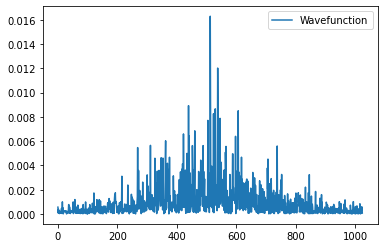

In [109]:
N = 10
layers = 8

qs = [cirq.GridQubit(0, i) for i in range(N)]
problem = (PositionOp(qs).op**2 + MomentumOp(qs).op**2)/2**(N-1)

vqe, circuit = make_vqe(qs, layers, problem)
results = optimize_vqe_gradient(vqe)

params_str = list(sorted(tfq.util.get_circuit_symbols(circuit))) 
params = [sympy.symbols(i) for i in params_str] 

final_state = tfq.layers.State()(circuit, symbol_names=params, symbol_values=vqe.trainable_variables).to_tensor()
wave_fn = tf.math.real(tf.math.conj(final_state) * final_state)[0]

plt.plot(wave_fn, label="Wavefunction")
plt.legend()
plt.show()

It is certainly guassian-ish. If we fit a guassian to it, we see the following:

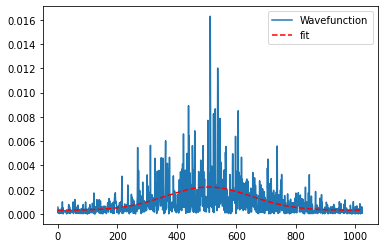

In [186]:
plt.plot(wave_fn, label="Wavefunction")
x = np.array([i for i in range(len(wave_fn))])
plt.plot(x, gauss(x, *gauss_fit(x, wave_fn)), '--r', label='fit')
plt.legend()
plt.show()

However, we can achieve better results if we trace out only a few of the qubits. Here we consider an example tracing out 3 of the qubits. We can trace out qubits using the trace_out function and specifying our system sizes (where $8 = 2^3$ and the remaining 7 qubits makes up the other $2^7 = 128$ states). We specify sv as True since we are inputing a statevector (not a density matrix). This results in the reduced/traced out density matrix. We then want to plot this, so we convert it to a statevector.

In [214]:
t = trace_out(wave_fn, 8, 128, sv=True)
w = pure_density_matrix_to_statevector(t)

Finally, we normalize the resulting statevector and fit a guassian to it. This last image shows an extremely good fit! Our CV-VQE did in fact learn the ground state guassian of our QHO!

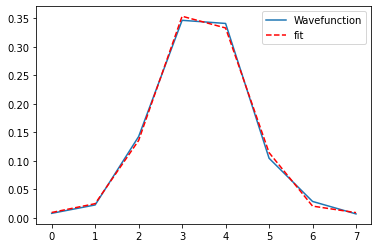

In [216]:
data = np.real(w.conj() * w)
x = np.array([i for i in range(len(data))])

plt.plot(data, label="Wavefunction")

plt.plot(x, gauss(x, *gauss_fit(x, data)), '--r', label='fit')
plt.legend()
plt.show()